In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import platform

In [18]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [19]:
TRAIN_DIR = 'data/processed/processed_train'
VAL_DIR = 'data/processed/processed_val'
TEST_DIR = 'data/processed/processed_test'
TRAIN_CSV = 'data/train.csv'
VAL_CSV = 'data/val.csv'
TEST_CSV = 'data/test.csv'
MODEL_SAVE_PATH = 'swin_tiny_best.pth'  

BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_CLASSES = 5
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EARLY_STOPPING_PATIENCE = 5
NUM_WORKERS = 0 if platform.system() == "Windows" else 2

print(f"Menggunakan device: {DEVICE}")
print(f"Path model terbaik akan disimpan di: {MODEL_SAVE_PATH}")

Menggunakan device: cpu
Path model terbaik akan disimpan di: swin_tiny_best.pth


In [20]:
class FundusProcessedDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [21]:
# Tambahkan Resize karena Swin Transformer mengharapkan input 224x224
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FundusProcessedDataset(TRAIN_CSV, TRAIN_DIR, transform=train_transform)
val_dataset = FundusProcessedDataset(VAL_CSV, VAL_DIR, transform=val_test_transform)
test_dataset = FundusProcessedDataset(TEST_CSV, TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("DataLoader dan Transformasi siap digunakan.")

DataLoader dan Transformasi siap digunakan.


In [22]:
# Ganti model ke Swin Transformer Tiny dengan bobot pre-trained terbaik
model = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)

# Dapatkan jumlah fitur input dari layer 'head' (classifier) Swin Transformer
in_features = model.head.in_features

# Ganti layer 'head' asli dengan layer Linear baru untuk 5 kelas
model.head = nn.Linear(in_features, NUM_CLASSES)

model = model.to(DEVICE)

# Loss, Optimizer, dan Scheduler tetap sama
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print("Model Swin Transformer berhasil dibuat dan siap untuk training.")
# print(model) # Uncomment untuk melihat arsitektur model

Model Swin Transformer berhasil dibuat dan siap untuk training.


In [23]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- VALIDASI ---
    model.eval()
    val_loss = 0
    val_correct = 0
    all_labels = []
    all_preds = []
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    val_loss /= len(val_dataset)
    val_acc = val_correct / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    scheduler.step(val_acc)

    # --- EARLY STOPPING & SIMPAN MODEL TERBAIK ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH) # Menggunakan path yang sudah didefinisikan
        print(f"Model terbaik disimpan ke '{MODEL_SAVE_PATH}' dengan Val Acc: {best_val_acc:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Performa tidak meningkat selama {EARLY_STOPPING_PATIENCE} epoch. Early stopping di epoch {epoch+1}.")
            break

Epoch 1/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.1268, Train Acc=0.5692, Val Loss=0.9258, Val Acc=0.6600
Model terbaik disimpan ke 'swin_tiny_best.pth' dengan Val Acc: 0.6600


Epoch 2/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.0233, Train Acc=0.6050, Val Loss=0.9704, Val Acc=0.6267


Epoch 3/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.9730, Train Acc=0.6400, Val Loss=0.8297, Val Acc=0.6800
Model terbaik disimpan ke 'swin_tiny_best.pth' dengan Val Acc: 0.6800


Epoch 4/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.9128, Train Acc=0.6633, Val Loss=0.7975, Val Acc=0.6933
Model terbaik disimpan ke 'swin_tiny_best.pth' dengan Val Acc: 0.6933


Epoch 5/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.8905, Train Acc=0.6675, Val Loss=0.7555, Val Acc=0.7133
Model terbaik disimpan ke 'swin_tiny_best.pth' dengan Val Acc: 0.7133


Epoch 6/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.8559, Train Acc=0.6667, Val Loss=0.8055, Val Acc=0.7067


Epoch 7/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.8464, Train Acc=0.6792, Val Loss=0.8273, Val Acc=0.6867


Epoch 8/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.8210, Train Acc=0.6908, Val Loss=0.7361, Val Acc=0.7400
Model terbaik disimpan ke 'swin_tiny_best.pth' dengan Val Acc: 0.7400


Epoch 9/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.7827, Train Acc=0.7050, Val Loss=0.7824, Val Acc=0.7133


Epoch 10/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.7707, Train Acc=0.7050, Val Loss=0.8062, Val Acc=0.7067


Epoch 11/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.7572, Train Acc=0.7075, Val Loss=0.8178, Val Acc=0.7133


Epoch 12/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.6942, Train Acc=0.7433, Val Loss=0.7922, Val Acc=0.7000


Epoch 13/20 - Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.6360, Train Acc=0.7558, Val Loss=0.8192, Val Acc=0.7267
Performa tidak meningkat selama 5 epoch. Early stopping di epoch 13.


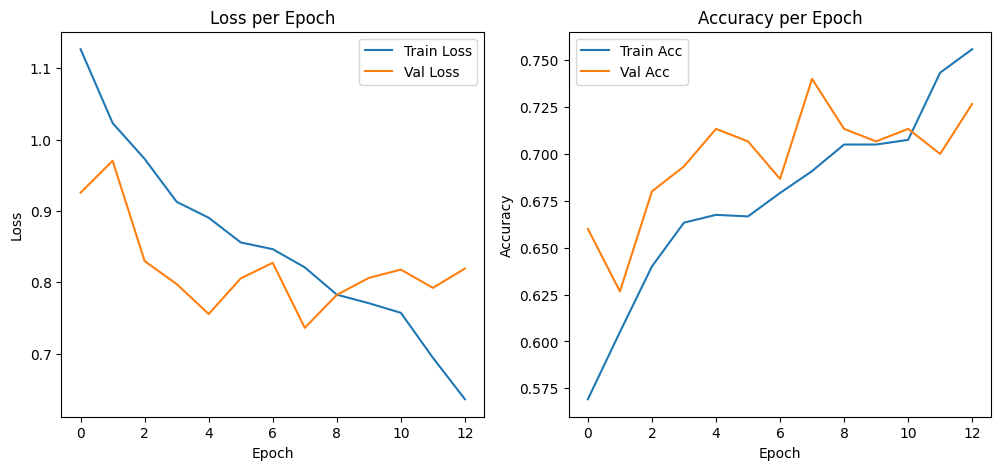

In [25]:
# Cell 8: Visualisasi Loss & Akurasi per Epoch
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()


Evaluasi pada data validasi (dari epoch terakhir):
              precision    recall  f1-score   support

  Severity 0       0.76      0.91      0.83        99
  Severity 1       0.50      0.27      0.35        26
  Severity 2       0.69      0.45      0.55        20
  Severity 3       0.75      1.00      0.86         3
  Severity 4       0.00      0.00      0.00         2

    accuracy                           0.73       150
   macro avg       0.54      0.53      0.52       150
weighted avg       0.69      0.73      0.70       150



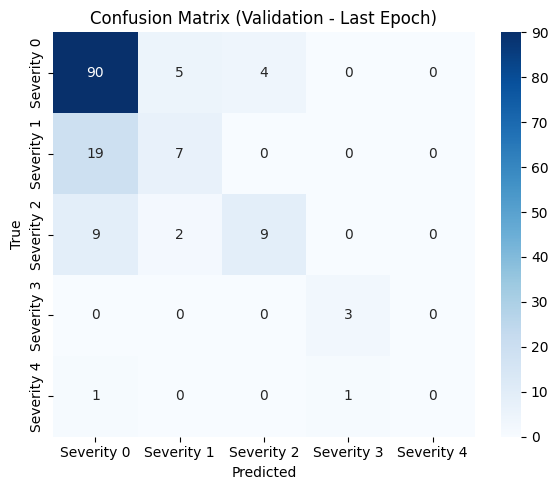

In [26]:
print("\nEvaluasi pada data validasi (dari epoch terakhir):")

# Pastikan all_labels dan all_preds tidak kosong
if all_labels and all_preds:
    print(classification_report(all_labels, all_preds, target_names=[f"Severity {i}" for i in range(NUM_CLASSES)], zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"Severity {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"Severity {i}" for i in range(NUM_CLASSES)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Validation - Last Epoch)')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data validasi untuk dievaluasi (kemungkinan training berhenti sebelum epoch pertama selesai).")

C:\Users\ALEXIS\AppData\Local\Temp\ipykernel_16808\2947265038.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))


Testing:   0%|          | 0/10 [00:00<?, ?it/s]


Evaluasi pada data test (menggunakan model terbaik):
              precision    recall  f1-score   support

  Severity 0       0.72      0.93      0.81        90
  Severity 1       0.17      0.04      0.07        23
  Severity 2       0.61      0.38      0.47        29
  Severity 3       0.44      0.80      0.57         5
  Severity 4       0.00      0.00      0.00         3

    accuracy                           0.67       150
   macro avg       0.39      0.43      0.38       150
weighted avg       0.59      0.67      0.61       150



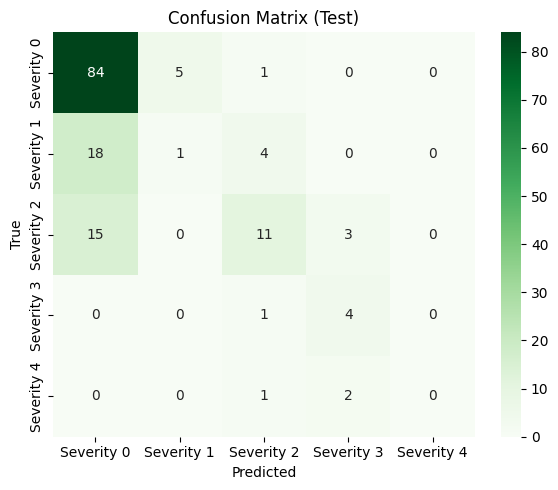

Akurasi Keseluruhan pada Data Test: 0.6667


,Precision,Recall,F1-Score
Class,,,
Severity 0,0.717949,0.933333,0.811594
Severity 1,0.166667,0.043478,0.068966
Severity 2,0.611111,0.379310,0.468085
Severity 3,0.444444,0.800000,0.571429
Severity 4,0.000000,0.000000,0.000000
Weighted Avg,0.589288,0.666667,0.607075


In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Muat bobot model terbaik yang telah disimpan
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

test_labels = []
test_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

print("\nEvaluasi pada data test (menggunakan model terbaik):")
print(classification_report(test_labels, test_preds, target_names=[f"Severity {i}" for i in range(NUM_CLASSES)], zero_division=0))

cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=[f"Severity {i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"Severity {i}" for i in range(NUM_CLASSES)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Buat tabel metrik
acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average=None, zero_division=0)
classes = [f"Severity {i}" for i in range(NUM_CLASSES)]

metrics_df = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Menambahkan rata-rata (weighted) untuk perbandingan yang lebih adil
avg_metrics = precision_recall_fscore_support(test_labels, test_preds, average='weighted', zero_division=0)
metrics_df.loc['Weighted Avg'] = ['Weighted Avg', avg_metrics[0], avg_metrics[1], avg_metrics[2]]
metrics_df = metrics_df.set_index('Class')

print(f"Akurasi Keseluruhan pada Data Test: {acc:.4f}")
display(metrics_df)

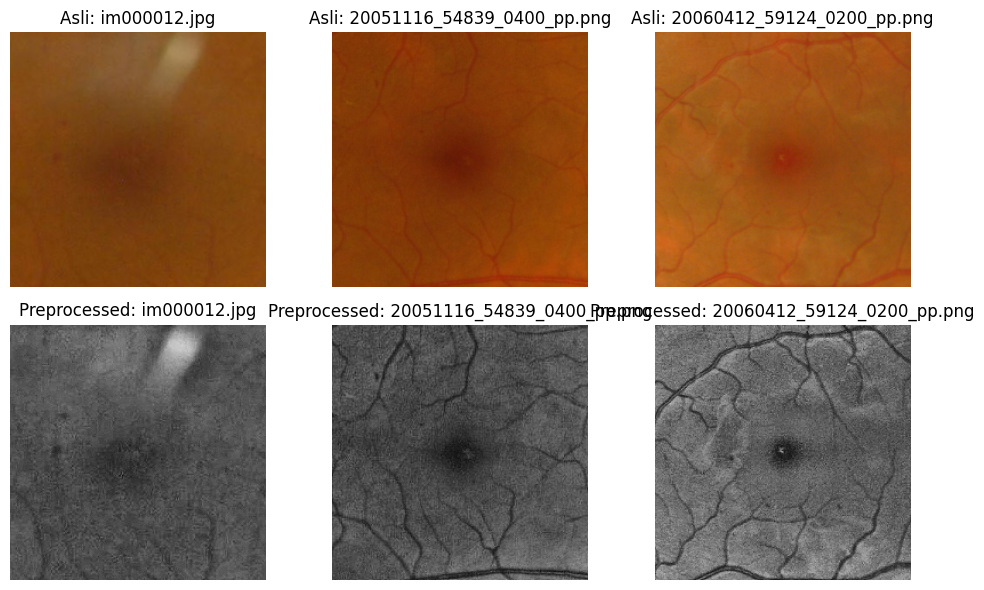

In [28]:
import matplotlib.pyplot as plt

# Pilih beberapa contoh gambar dari data/raw dan data/processed/processed_train
raw_dir = 'data/raw'
processed_dir = 'data/processed/processed_train'
sample_df = pd.read_csv('data/train.csv').sample(3, random_state=42)

plt.figure(figsize=(10, 6))
for i, row in enumerate(sample_df.itertuples()):
    raw_img = cv2.imread(os.path.join(raw_dir, row.image_id))
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    proc_img = cv2.imread(os.path.join(processed_dir, row.image_id))
    proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(raw_img)
    plt.title(f"Asli: {row.image_id}")
    plt.axis('off')
    plt.subplot(2, 3, i+4)
    plt.imshow(proc_img)
    plt.title(f"Preprocessed: {row.image_id}")
    plt.axis('off')
plt.tight_layout()
plt.show()